# Training Data EDA — Post Data-Leakage Fix

Quick inspection of the new training parquet generated by `generate_dataset.py` with:
- **Sequential `time_idx`** per group (no longer minutes-since-epoch)
- **`month_sin` / `month_cos`** temporal features added

Goals:
1. Verify schema — new columns present, old leaky `time_idx` replaced
2. Confirm `time_idx` is sequential per group (0, 1, 2, ...)
3. Confirm `relative_time_idx` differences are all 1 (no leakage)
4. Spot-check `month_sin`/`month_cos` values
5. Quick distribution check on key features and target

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("whitegrid")
pd.set_option("display.max_columns", 40)
pd.set_option("display.width", 200)

## 1. Load Data

Update the path below once the Dataflow job completes and you've copied the parquet locally.

In [2]:
# Option A: Load from GCS directly
# df = pd.read_parquet("gs://ml-pipelines-headway-prediction/temp/training_data.parquet")

# Option B: Load from local copy
df = pd.read_parquet("../local_artifacts/processed_data/training_data.parquet")

print(f"Shape: {df.shape}")
print(f"Columns: {list(df.columns)}")

Shape: (146758, 24)
Columns: ['trip_uid', 'arrival_time', 'group_id', 'route_id', 'time_idx', 'day_of_week', 'hour_sin', 'hour_cos', 'month_sin', 'month_cos', 'regime_id', 'track_id', 'service_headway', 'preceding_train_gap', 'preceding_route_id', 'empirical_median', 'upstream_headway_14th', 'travel_time_14th', 'travel_time_14th_deviation', 'travel_time_23rd', 'travel_time_23rd_deviation', 'travel_time_34th', 'travel_time_34th_deviation', 'stops_at_23rd']


## 2. Schema Check

In [3]:
# Verify expected columns exist
expected_new = ["month_sin", "month_cos"]
for col in expected_new:
    assert col in df.columns, f"MISSING: {col}"
    print(f"✓ {col} present")

print()
df.dtypes

✓ month_sin present
✓ month_cos present



trip_uid                       object
arrival_time                   object
group_id                       object
route_id                       object
time_idx                        int64
day_of_week                     int64
hour_sin                      float64
hour_cos                      float64
month_sin                     float64
month_cos                     float64
regime_id                      object
track_id                       object
service_headway               float64
preceding_train_gap           float64
preceding_route_id             object
empirical_median              float64
upstream_headway_14th         float64
travel_time_14th              float64
travel_time_14th_deviation    float64
travel_time_23rd              float64
travel_time_23rd_deviation    float64
travel_time_34th              float64
travel_time_34th_deviation    float64
stops_at_23rd                 float64
dtype: object

In [4]:
df.head(10)

,trip_uid,arrival_time,group_id,route_id,time_idx,day_of_week,hour_sin,hour_cos,month_sin,month_cos,regime_id,track_id,service_headway,preceding_train_gap,preceding_route_id,empirical_median,upstream_headway_14th,travel_time_14th,travel_time_14th_deviation,travel_time_23rd,travel_time_23rd_deviation,travel_time_34th,travel_time_34th_deviation,stops_at_23rd
0,1739771940_C..S04R,2025-02-17T11:34:54+00:00,C_South,C,0,0,0.113203,-0.993572,0.724793,0.688967,Day,A1,24.300000,16.500000,E,10.416667,24.383333,1.916667,-0.166667,3.250000,-0.250000,4.833333,-0.250000,1.0
1,1739773140_C..S04R,2025-02-17T11:50:14+00:00,C_South,C,1,0,0.043619,-0.999048,0.724793,0.688967,Day,A1,15.333333,11.750000,E,10.416667,14.333333,2.916667,0.833333,4.333333,0.833333,5.666667,0.583333,1.0
2,1739774340_C..S04R,2025-02-17T12:11:10+00:00,C_South,C,2,0,-0.047978,-0.998848,0.724793,0.688967,Day,A1,20.933333,4.250000,E,9.633333,21.850000,2.000000,-0.133333,3.433333,-0.150000,5.166667,-0.033333,1.0
3,1739775270_C..S04R,2025-02-17T12:26:00+00:00,C_South,C,3,0,-0.113203,-0.993572,0.724793,0.688967,Day,A1,14.833333,4.433333,E,9.633333,14.983333,1.850000,-0.283333,3.166667,-0.416667,4.750000,-0.450000,1.0
4,1739776080_C..S04R,2025-02-17T12:40:00+00:00,C_South,C,4,0,-0.173648,-0.984808,0.724793,0.688967,Day,A1,14.000000,7.150000,E,9.633333,13.616667,2.233333,0.100000,3.766667,0.183333,5.250000,0.050000,1.0
5,1739776800_C..S04R,2025-02-17T12:54:54+00:00,C_South,C,5,0,-0.233445,-0.972370,0.724793,0.688967,Day,A1,14.900000,1.900000,E,9.633333,14.816667,2.316667,0.183333,3.816667,0.233333,5.400000,0.200000,1.0
6,1739777520_C..S04R,2025-02-17T13:05:10+00:00,C_South,C,6,0,-0.279829,-0.960050,0.724793,0.688967,Day,A1,10.266667,8.483333,E,8.850000,10.650000,1.933333,-0.150000,3.433333,-0.150000,5.150000,-0.016667,1.0
7,1739778240_C..S04R,2025-02-17T13:16:04+00:00,C_South,C,7,0,-0.325568,-0.945519,0.724793,0.688967,Day,A1,10.900000,6.583333,E,8.850000,10.916667,1.916667,-0.166667,3.250000,-0.333333,4.833333,-0.333333,1.0
8,1739778960_C..S04R,2025-02-17T13:30:42+00:00,C_South,C,8,0,-0.382683,-0.923880,0.724793,0.688967,Day,A1,14.633333,7.883333,E,8.850000,14.083333,2.466667,0.383333,4.000000,0.416667,5.716667,0.550000,1.0
9,1739779680_C..S04R,2025-02-17T13:40:34+00:00,C_South,C,9,0,-0.422618,-0.906308,0.724793,0.688967,Day,A1,9.866667,6.333333,E,8.850000,10.333333,2.000000,-0.083333,3.416667,-0.166667,5.000000,-0.166667,1.0


In [5]:
df.describe()

,time_idx,day_of_week,hour_sin,hour_cos,month_sin,month_cos,service_headway,preceding_train_gap,empirical_median,upstream_headway_14th,travel_time_14th,travel_time_14th_deviation,travel_time_23rd,travel_time_23rd_deviation,travel_time_34th,travel_time_34th_deviation,stops_at_23rd
count,146758.000000,146758.000000,146758.000000,146758.000000,146758.000000,146758.000000,146758.000000,146757.000000,146758.000000,146676.000000,146678.000000,146678.000000,146758.000000,146758.000000,146705.000000,146705.000000,146758.000000
mean,25419.100628,2.741575,-0.247151,0.078723,-0.011138,-0.001279,9.376644,7.060923,8.915333,9.359619,2.230964,0.142395,3.774118,0.174686,5.110269,0.220014,0.680672
std,15686.916925,1.890210,0.611700,0.747362,0.706016,0.708112,5.948147,28.657898,3.916080,5.874274,0.884353,0.882045,0.982248,0.977572,1.435727,1.385655,0.466218
min,0.000000,0.000000,-1.000000,-1.000000,-0.999857,-0.999857,0.516667,0.000000,3.950000,0.000000,0.016667,-2.916667,0.016667,-4.200000,-8.516667,-13.683333,0.000000
25%,12112.250000,1.000000,-0.801254,-0.725374,-0.724793,-0.713053,5.166667,2.633333,5.900000,5.216667,2.000000,-0.083333,3.500000,-0.083333,4.583333,-0.183333,0.000000
50%,24342.000000,3.000000,-0.366501,0.207912,-0.016889,-0.016889,8.316667,4.583333,8.333333,8.333333,2.083333,0.000000,3.773551,0.180276,5.000000,0.000000,1.000000
75%,37652.000000,4.000000,0.216440,0.831470,0.688967,0.713053,12.033333,8.000000,10.666667,12.000000,2.250000,0.133333,3.773551,0.180276,5.333333,0.300000,1.000000
max,57626.000000,6.000000,1.000000,1.000000,1.000000,1.000000,89.416667,4568.666667,87.166667,89.400000,61.416667,59.300000,76.000000,72.383333,77.583333,72.400000,1.000000


## 3. Verify Sequential `time_idx` (Critical)

The whole point of this fix: `time_idx` should be 0, 1, 2, ... within each `group_id`.
Differences between consecutive rows in the same group should always be 1.

In [6]:
# Check time_idx starts at 0 for each group
min_per_group = df.groupby("group_id")["time_idx"].min()
print("Min time_idx per group:")
print(min_per_group)
assert (min_per_group == 0).all(), "ERROR: time_idx does not start at 0 for all groups!"
print("\n✓ All groups start at time_idx=0")

Min time_idx per group:
group_id
A_South        0
C_South        0
E_South        0
OTHER_South    0
Name: time_idx, dtype: int64

✓ All groups start at time_idx=0


In [7]:
# Check time_idx is strictly sequential (diff == 1) within each group
diffs = df.sort_values(["group_id", "time_idx"]).groupby("group_id")["time_idx"].diff().dropna()

non_one = diffs[diffs != 1]
print(f"Total consecutive diffs: {len(diffs)}")
print(f"Non-1 diffs: {len(non_one)}")

if len(non_one) > 0:
    print("\n⚠ WARNING: Found non-sequential time_idx gaps:")
    print(non_one.head(20))
else:
    print("\n✓ time_idx is perfectly sequential within every group")

Total consecutive diffs: 146754
Non-1 diffs: 0

✓ time_idx is perfectly sequential within every group


In [8]:
# Max time_idx per group = count of observations - 1
summary = df.groupby("group_id").agg(
    count=("time_idx", "count"),
    max_idx=("time_idx", "max"),
)
summary["expected_max"] = summary["count"] - 1
summary["match"] = summary["max_idx"] == summary["expected_max"]
print(summary)
assert summary["match"].all(), "ERROR: max time_idx doesn't match count-1!"
print("\n✓ max(time_idx) == count-1 for all groups")

             count  max_idx  expected_max  match
group_id                                        
A_South      54368    54367         54367   True
C_South      34412    34411         34411   True
E_South      57627    57626         57626   True
OTHER_South    351      350           350   True

✓ max(time_idx) == count-1 for all groups


## 4. Verify `month_sin` / `month_cos`

In [9]:
# month_sin and month_cos should be in [-1, 1]
for col in ["month_sin", "month_cos"]:
    vmin, vmax = df[col].min(), df[col].max()
    print(f"{col}: min={vmin:.4f}, max={vmax:.4f}")
    assert -1.0 <= vmin and vmax <= 1.0, f"{col} out of range!"

# Verify sin²+cos² ≈ 1 (unit circle)
norm = df["month_sin"]**2 + df["month_cos"]**2
print(f"\nsin²+cos² — mean: {norm.mean():.6f}, std: {norm.std():.6f}")
assert np.allclose(norm, 1.0, atol=1e-6), "month sin/cos not on unit circle!"
print("✓ month_sin/month_cos on unit circle")

month_sin: min=-0.9999, max=1.0000
month_cos: min=-0.9999, max=1.0000

sin²+cos² — mean: 1.000000, std: 0.000000
✓ month_sin/month_cos on unit circle


In [10]:
# Similarly verify hour_sin/hour_cos
hour_norm = df["hour_sin"]**2 + df["hour_cos"]**2
print(f"hour sin²+cos² — mean: {hour_norm.mean():.6f}, std: {hour_norm.std():.6f}")
assert np.allclose(hour_norm, 1.0, atol=1e-6), "hour sin/cos not on unit circle!"
print("✓ hour_sin/hour_cos on unit circle")

hour sin²+cos² — mean: 1.000000, std: 0.000000
✓ hour_sin/hour_cos on unit circle


## 5. Target Distribution (`service_headway`)

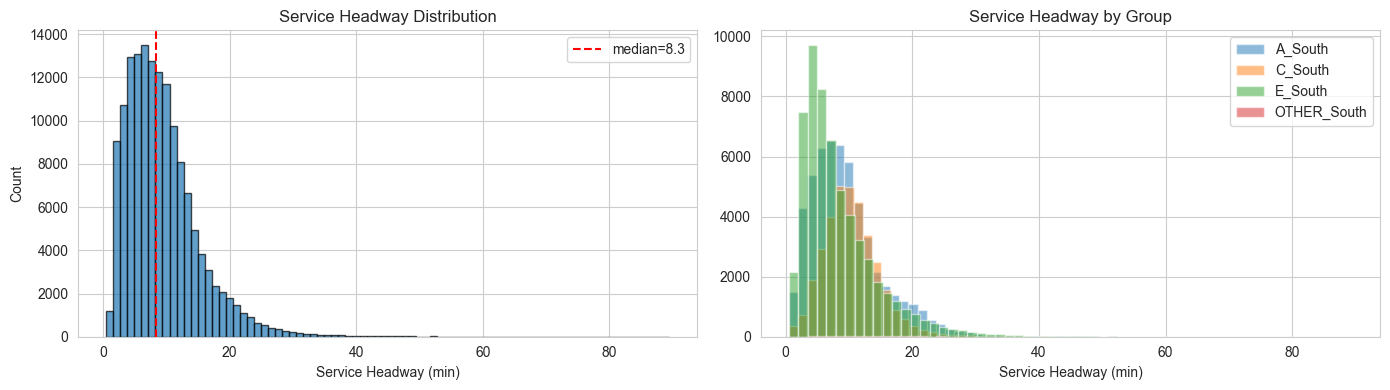

               count   mean    std   min   25%    50%    75%    max
group_id                                                           
A_South      54368.0   9.64   5.99  0.53  5.47   8.50  12.17  87.58
C_South      34412.0  10.41   4.72  0.52  7.40   9.95  12.77  88.17
E_South      57627.0   8.48   6.36  0.52  4.17   6.68  10.92  89.42
OTHER_South    351.0  14.72  10.91  0.68  8.50  12.83  17.71  87.17


In [11]:
fig, axes = plt.subplots(1, 2, figsize=(14, 4))

# Histogram
axes[0].hist(df["service_headway"].dropna(), bins=80, edgecolor="black", alpha=0.7)
axes[0].set_xlabel("Service Headway (min)")
axes[0].set_ylabel("Count")
axes[0].set_title("Service Headway Distribution")
axes[0].axvline(df["service_headway"].median(), color="red", linestyle="--", label=f"median={df['service_headway'].median():.1f}")
axes[0].legend()

# By group
for gid, group in df.groupby("group_id"):
    axes[1].hist(group["service_headway"].dropna(), bins=60, alpha=0.5, label=gid)
axes[1].set_xlabel("Service Headway (min)")
axes[1].set_title("Service Headway by Group")
axes[1].legend()

plt.tight_layout()
plt.show()

print(df.groupby("group_id")["service_headway"].describe().round(2))

## 6. Nulls & Completeness

In [12]:
null_counts = df.isnull().sum()
null_pct = (null_counts / len(df) * 100).round(2)
null_report = pd.DataFrame({"nulls": null_counts, "pct": null_pct})
print(null_report[null_report["nulls"] > 0] if null_report["nulls"].any() else "✓ No nulls in any column")

                            nulls   pct
preceding_train_gap             1  0.00
preceding_route_id              1  0.00
upstream_headway_14th          82  0.06
travel_time_14th               80  0.05
travel_time_14th_deviation     80  0.05
travel_time_34th               53  0.04
travel_time_34th_deviation     53  0.04


## 7. Key Feature Correlations with Target

In [13]:
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
corr_with_target = df[numeric_cols].corr()["service_headway"].drop("service_headway").sort_values(ascending=False)
print("Correlation with service_headway:\n")
print(corr_with_target.round(4))

Correlation with service_headway:

upstream_headway_14th         0.9806
empirical_median              0.6186
hour_sin                      0.3574
day_of_week                   0.1836
travel_time_34th              0.1354
preceding_train_gap           0.1231
travel_time_34th_deviation    0.1091
travel_time_23rd_deviation    0.0977
travel_time_14th              0.0962
travel_time_14th_deviation    0.0961
travel_time_23rd              0.0942
stops_at_23rd                 0.0913
month_cos                     0.0100
month_sin                     0.0096
time_idx                     -0.0280
hour_cos                     -0.1226
Name: service_headway, dtype: float64


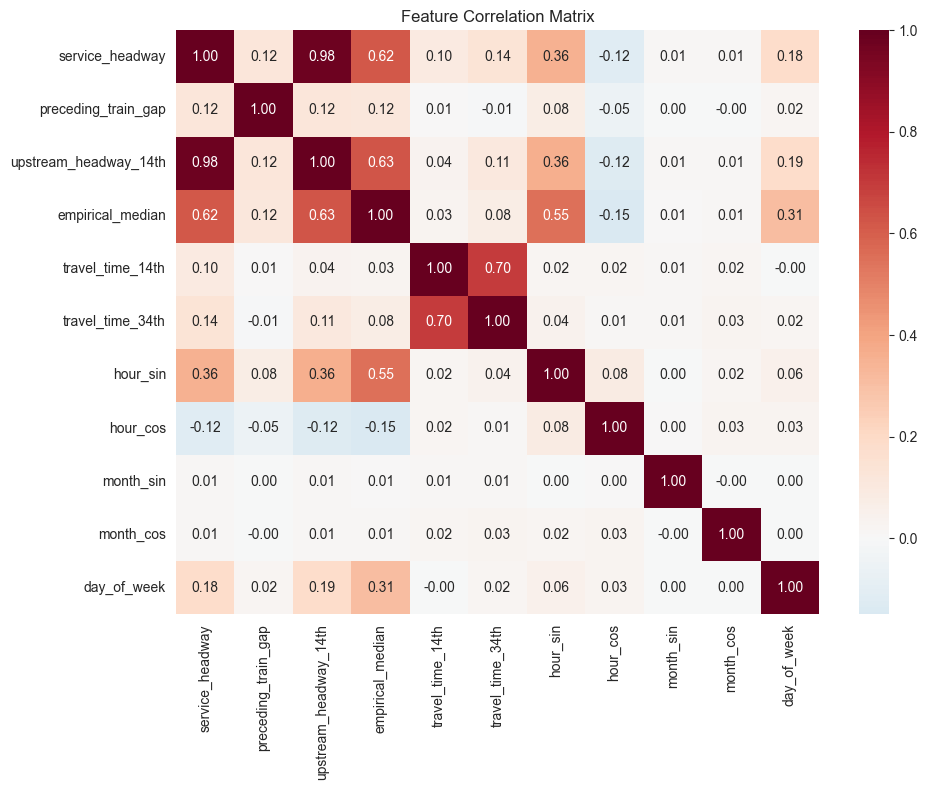

In [14]:
# Heatmap of top features
top_features = ["service_headway", "preceding_train_gap", "upstream_headway_14th", 
                "empirical_median", "travel_time_14th", "travel_time_34th",
                "hour_sin", "hour_cos", "month_sin", "month_cos", "day_of_week"]
top_features = [c for c in top_features if c in df.columns]

fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(df[top_features].corr(), annot=True, fmt=".2f", cmap="RdBu_r", center=0, ax=ax)
ax.set_title("Feature Correlation Matrix")
plt.tight_layout()
plt.show()

## 8. Data Leakage Sanity Check

The old `time_idx` (minutes-since-epoch) had differences that equaled headway.
With sequential `time_idx`, the difference is always 1 — verify no correlation.

In [17]:
# time_idx diff should be constant 1 — zero variance means NaN correlation (that's a pass!)
df_sorted = df.sort_values(["group_id", "time_idx"])
df_sorted["time_idx_diff"] = df_sorted.groupby("group_id")["time_idx"].diff()

valid = df_sorted.dropna(subset=["time_idx_diff", "service_headway"])
unique_diffs = valid["time_idx_diff"].unique()
print(f"time_idx_diff unique values: {unique_diffs}")

if len(unique_diffs) == 1 and unique_diffs[0] == 1.0:
    print("✓ No leakage — time_idx_diff is constant 1 (zero variance, no information content)")
else:
    corr = valid["time_idx_diff"].corr(valid["service_headway"])
    print(f"Correlation between time_idx_diff and service_headway: {corr:.6f}")
    if abs(corr) < 0.01 or np.isnan(corr):
        print("✓ No leakage detected")
    else:
        print("⚠ WARNING: Unexpected correlation — investigate!")

time_idx_diff unique values: [1.]
✓ No leakage — time_idx_diff is constant 1 (zero variance, no information content)


## 9. Group Counts & Temporal Coverage

In [16]:
print("Rows per group:")
print(df["group_id"].value_counts())
print(f"\nTotal rows: {len(df)}")
print(f"Groups: {df['group_id'].nunique()}")
print(f"Routes: {df['route_id'].unique()}")
print(f"Tracks: {df['track_id'].unique()}")
print(f"Regimes: {df['regime_id'].unique()}")

Rows per group:
group_id
E_South        57627
A_South        54368
C_South        34412
OTHER_South      351
Name: count, dtype: int64

Total rows: 146758
Groups: 4
Routes: ['C' 'OTHER' 'E' 'A']
Tracks: ['A1' 'A3']
Regimes: ['Day' 'Night']
